# Algoritmo support vector machine

## Imports

In [1]:
# importamos las librerias y bibliotecas que utilizaremos para el algoritmo de support vector machine
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

## Funciones auxiliares

In [2]:
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [3]:
# Representación gráfica del límite de decisión
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

## Lectura del conjunto de datos

In [4]:
#Lectura del dataset 
df = pd.read_csv('dataset-equilibrado-3.csv')

## Visualización preliminar de la información

In [5]:
# Vista de los datos cargados
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,72918,Female,53.0,1,0,Yes,Private,Urban,62.55,30.3,Unknown,1
1,72911,Female,57.0,1,0,Yes,Private,Rural,129.54,60.9,smokes,0
2,72898,Female,67.0,1,1,Yes,Private,Rural,199.24,33.9,never smoked,1
3,72882,Male,47.0,0,0,Yes,Private,Rural,75.30,25.0,formerly smoked,0
4,72861,Female,52.0,0,0,Yes,Private,Urban,69.30,20.1,never smoked,0


In [6]:
#Validamos la cantidad de ejemplos que posee el dataset
df["stroke"].value_counts()

0    1600
1     783
Name: stroke, dtype: int64

## Primera preparación del conjunto de datos

In [7]:
#Función para transformar las columnas categoricas a numericas
df_new = pd.get_dummies(df, columns=['gender','ever_married','work_type','Residence_type','smoking_status'])

In [8]:
#Validamos que los cambios se aplicarón correctamente 
df_new

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,72918,53.0,1,0,62.55,30.3,1,1,0,0,...,0,1,0,0,0,1,1,0,0,0
1,72911,57.0,1,0,129.54,60.9,0,1,0,0,...,0,1,0,0,1,0,0,0,0,1
2,72898,67.0,1,1,199.24,33.9,1,1,0,0,...,0,1,0,0,1,0,0,0,1,0
3,72882,47.0,0,0,75.30,25.0,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0
4,72861,52.0,0,0,69.30,20.1,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2378,132,80.0,0,0,84.86,NaN,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
2379,129,24.0,0,0,97.55,26.2,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0
2380,99,31.0,0,0,108.89,52.3,0,1,0,1,...,0,1,0,0,0,1,1,0,0,0
2381,84,55.0,0,0,89.17,31.5,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0


In [9]:
#Eliminamos datos que son irrelevantes y que podrian alterar el comportamiento del algoritmo
df_new = df_new.drop(["id"], axis=1)

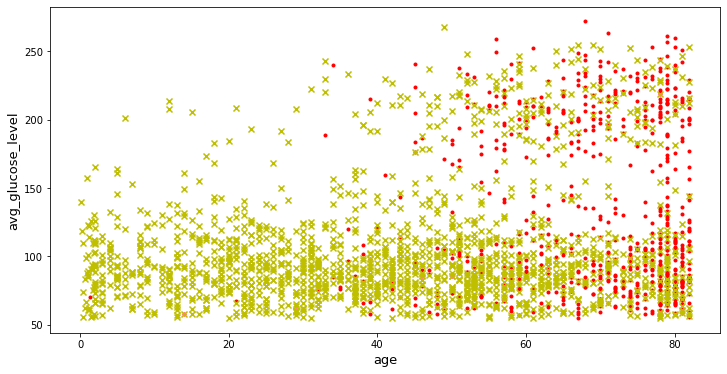

In [10]:
# Representación gráfica de dos características
plt.figure(figsize=(12, 6))
plt.scatter(df_new["age"][df_new['stroke'] == 1], df_new["avg_glucose_level"][df_new['stroke'] == 1], c="r", marker=".")
plt.scatter(df_new["age"][df_new['stroke'] == 0], df_new["avg_glucose_level"][df_new['stroke'] == 0], c="y", marker="x")
plt.xlabel("age", fontsize=13)
plt.ylabel("avg_glucose_level", fontsize=13)
plt.show()

## División del conjunto de datos

In [11]:
# Division del conjunto en los diferentes subconjuntos
train_set, val_set, test_set = train_val_test_split(df_new, stratify='stroke')

In [12]:
#Verificamos las particiones realizadas
print("Longitud del Training Set:", len(train_set))
print("Longitud del Validation Set:", len(val_set))
print("Longitud del Test Set:", len(test_set))

Longitud del Training Set: 1429
Longitud del Validation Set: 477
Longitud del Test Set: 477


In [13]:
# Conjunto de datos de entrenamiento
X_train = train_set.drop("stroke", axis=1)
y_train = train_set["stroke"].copy()

In [14]:
# Conjunto de datos de validación
X_val = val_set.drop("stroke", axis=1)
y_val = val_set["stroke"].copy()

In [15]:
# Conjunto de datos de pruebas
X_test = test_set.drop("stroke", axis=1)
y_test = test_set["stroke"].copy()

## Segunda preparación del conjunto de datos

In [16]:
# Construcción de un pipeline para rellenar los valores nulos con la mediana y scalar los datos 
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('rbst_scaler', RobustScaler()),
    ])

In [17]:
# Rellenamos los valores nulos con la mediana y scalamos los datos
X_train_prep = num_pipeline.fit_transform(X_train)
X_val_prep = num_pipeline.fit_transform(X_val)
X_test_prep = num_pipeline.fit_transform(X_test)

In [18]:
# Transformamos el resultado a un DataFrame de Pandas
X_train_prep = pd.DataFrame(X_train_prep, columns=X_train.columns, index=y_train.index)
X_val_prep = pd.DataFrame(X_val_prep, columns=X_val.columns, index=y_val.index)
X_test_prep = pd.DataFrame(X_test_prep, columns=X_test.columns, index=y_test.index)

In [19]:
#Validamos que los cambios se aplicaron correctamente 
X_train_prep

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
2082,-0.315789,0.0,0.0,-0.197073,-0.141026,-1.0,1.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2367,-0.315789,0.0,0.0,2.230439,5.576923,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,1.0,0.0
118,0.289474,0.0,0.0,-0.727805,1.051282,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
959,0.184211,0.0,0.0,0.058341,-0.230769,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1592,-0.500000,0.0,0.0,0.232390,0.282051,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2370,-1.105263,0.0,0.0,-0.408780,-0.961538,0.0,0.0,1.0,-1.0,0.0,0.0,-1.0,0.0,1.0,1.0,-1.0,1.0,0.0,0.0,0.0
342,0.631579,0.0,0.0,-0.284488,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
39,-0.763158,0.0,0.0,0.821854,-0.141026,-1.0,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1486,-0.605263,0.0,0.0,-0.144195,0.948718,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## SMV: Kernel lineal

### Conjunto de datos reducido

**Entrenamiento del algoritmo con un conjunto de datos reducido**

In [20]:
# Reducimos el conjunto de datos para representarlo gráficamente
X_train_reduced = X_train_prep[["age", "avg_glucose_level"]].copy()
X_val_reduced = X_val_prep[["age", "avg_glucose_level"]].copy()

In [21]:
X_train_reduced

,age,avg_glucose_level
2082,-0.315789,-0.197073
2367,-0.315789,2.230439
118,0.289474,-0.727805
959,0.184211,0.058341
1592,-0.500000,0.232390
...,...,...
2370,-1.105263,-0.408780
342,0.631579,-0.284488
39,-0.763158,0.821854
1486,-0.605263,-0.144195


In [22]:
from sklearn.svm import SVC

# SVM Large Margin Classification
svm_clf = SVC(kernel="linear", C=50)
svm_clf.fit(X_train_reduced, y_train)

SVC(C=50, kernel='linear')

**Representación del límite de decisión**

In [23]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

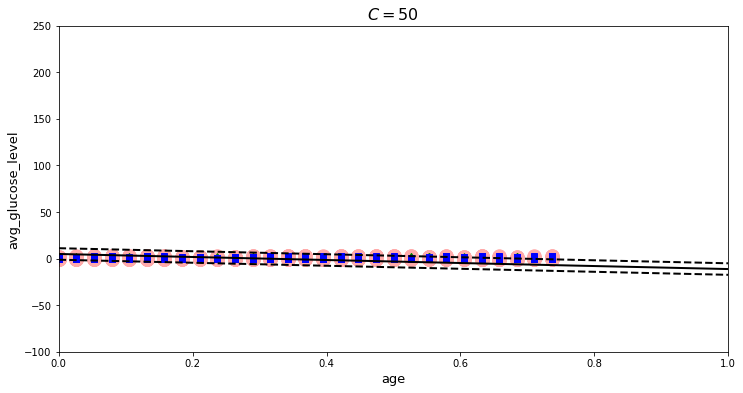

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(X_train_reduced.values[:, 0][y_train==1], X_train_reduced.values[:, 1][y_train==1], "g^")
plt.plot(X_train_reduced.values[:, 0][y_train==0], X_train_reduced.values[:, 1][y_train==0], "bs")
plot_svc_decision_boundary(svm_clf, 0, 1)
plt.title("$C = {}$".format(svm_clf.C), fontsize=16)
plt.axis([0, 1, -100, 250])
plt.xlabel("age", fontsize=13)
plt.ylabel("avg_glucose_level", fontsize=13)
plt.show()

**Predicción con un conjunto de datos reducido**

In [25]:
y_pred = svm_clf.predict(X_val_reduced)

In [26]:
print("F1 Score:", f1_score(y_pred, y_val, pos_label=0))

F1 Score: 0.8274760383386581


In [27]:
from sklearn.metrics import accuracy_score
print('Accuracy: {:.3f}'.format(accuracy_score(y_val,y_pred)))

Accuracy: 0.774


### Conjunto de datos completo

In [32]:
# Entrenamiento con todo el conjunto de datos
from sklearn.svm import SVC

svm_clf = SVC(kernel="linear", C=1)
svm_clf.fit(X_train_prep, y_train)

SVC(C=1, kernel='linear')

In [33]:
y_pred = svm_clf.predict(X_val_prep)

In [34]:
print("F1 Score:", f1_score(y_pred, y_val, pos_label=1))

F1 Score: 0.7210031347962382


In [35]:
print('Accuracy: {:.3f}'.format(accuracy_score(y_val,y_pred)))

Accuracy: 0.813


## SMV: Kernel no lineal

### Polynomial Kernel (I)

**Entrenamiento del algoritmo con un conjunto de datos reducido**

In [36]:
from sklearn.datasets import make_moons
from sklearn.svm import LinearSVC
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=20, loss="hinge", random_state=42, max_iter=100000))
    ])

polynomial_svm_clf.fit(X_train_reduced, y_train)

D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf',
                 LinearSVC(C=20, loss='hinge', max_iter=100000,
                           random_state=42))])

In [37]:
def plot_dataset(X, y):
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "b.")
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "g.")

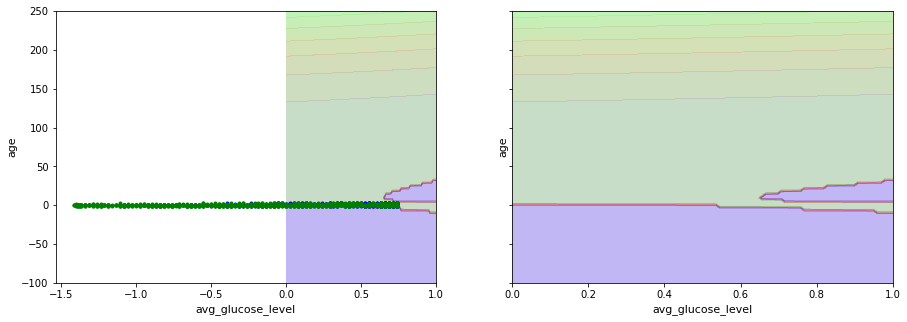

In [38]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

fig, axes = plt.subplots(ncols=2, figsize=(15,5), sharey=True)
plt.sca(axes[0])
plot_dataset(X_train_reduced.values, y_train)
plot_predictions(polynomial_svm_clf, [0, 1, -100, 250])
plt.xlabel("avg_glucose_level", fontsize=11)
plt.ylabel("age", fontsize=11)
plt.sca(axes[1])
plot_predictions(polynomial_svm_clf, [0, 1, -100, 250])
plt.xlabel("avg_glucose_level", fontsize=11)
plt.ylabel("age", fontsize=11)
plt.show()

**Predicción con el conjunto de datos reducido**

In [39]:
y_pred = polynomial_svm_clf.predict(X_val_reduced)

In [40]:
print("F1 Score:", f1_score(y_pred, y_val, pos_label=0))

F1 Score: 0.8372827804107424


In [41]:
print('Accuracy: {:.3f}'.format(accuracy_score(y_val,y_pred)))

Accuracy: 0.784


### Polynomial Kernel (II)

In [42]:
svm_clf = SVC(kernel="poly", degree=3, coef0=10, C=20)
svm_clf.fit(X_train_reduced, y_train)

SVC(C=20, coef0=10, kernel='poly')

**Representación del límite de decisión**

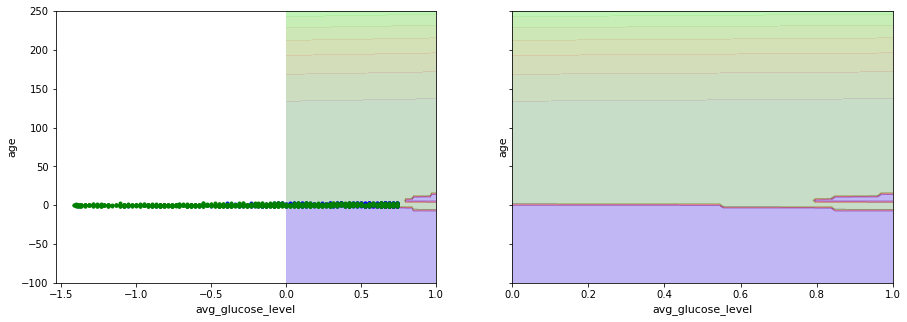

In [43]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5), sharey=True)
plt.sca(axes[0])
plot_dataset(X_train_reduced.values, y_train)
plot_predictions(svm_clf, [0, 1, -100, 250])
plt.xlabel("avg_glucose_level", fontsize=11)
plt.ylabel("age", fontsize=11)
plt.sca(axes[1])
plot_predictions(svm_clf, [0, 1, -100, 250])
plt.xlabel("avg_glucose_level", fontsize=11)
plt.ylabel("age", fontsize=11)
plt.show()

**Predicción con un conjunto de datos reducido**

In [44]:
y_pred = svm_clf.predict(X_val_reduced)

In [45]:
print("F1 Score:", f1_score(y_pred, y_val, pos_label=0))

F1 Score: 0.8372827804107424


In [47]:
print('Accuracy: {:.3f}'.format(accuracy_score(y_val,y_pred)))

Accuracy: 0.784


**Predicción con el conjunto de datos completo**

In [48]:
svm_clf = SVC(kernel="poly", degree=3, coef0=10, C=40)
svm_clf.fit(X_train_prep, y_train)

SVC(C=40, coef0=10, kernel='poly')

In [49]:
y_pred = svm_clf.predict(X_val_prep)

In [50]:
print("F1 Score:", f1_score(y_pred, y_val, pos_label=1))

F1 Score: 0.5159010600706714


In [51]:
print('Accuracy: {:.3f}'.format(accuracy_score(y_val,y_pred)))

Accuracy: 0.713


### Gaussian Kernel

**Entrenamiento del algoritmo con un conjunto de datos reducido**

In [52]:
rbf_kernel_svm_clf = Pipeline([
            ("scaler", RobustScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=0.5, C=1000))
        ])

rbf_kernel_svm_clf.fit(X_train_reduced, y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('svm_clf', SVC(C=1000, gamma=0.5))])

**Representación del límite de decisión**

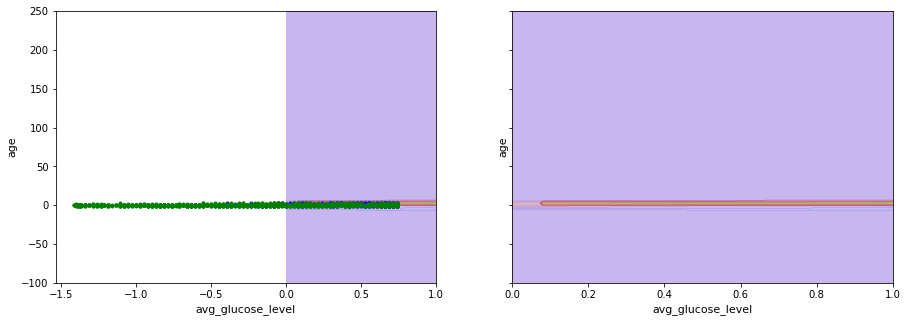

In [53]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5), sharey=True)
plt.sca(axes[0])
plot_dataset(X_train_reduced.values, y_train)
plot_predictions(rbf_kernel_svm_clf, [0, 1, -100, 250])
plt.xlabel("avg_glucose_level", fontsize=11)
plt.ylabel("age", fontsize=11)
plt.sca(axes[1])
plot_predictions(rbf_kernel_svm_clf, [0, 1, -100, 250])
plt.xlabel("avg_glucose_level", fontsize=11)
plt.ylabel("age", fontsize=11)
plt.show()

**Predicción con un conjunto de datos reducido**

In [54]:
y_pred = rbf_kernel_svm_clf.predict(X_val_reduced)

In [55]:
print("F1 Score:", f1_score(y_pred, y_val, pos_label=0))

F1 Score: 0.8264984227129337


In [56]:
print('Accuracy: {:.3f}'.format(accuracy_score(y_val,y_pred)))

Accuracy: 0.769


**Predicción con un conjunto de datos completo**

In [57]:
rbf_kernel_svm_clf = Pipeline([
            ("scaler", RobustScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=0.05, C=1000))
        ])

rbf_kernel_svm_clf.fit(X_train_prep, y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('svm_clf', SVC(C=1000, gamma=0.05))])

In [58]:
y_pred = rbf_kernel_svm_clf.predict(X_val_prep)

In [59]:
print("F1 Score:", f1_score(y_pred, y_val, pos_label=1))

F1 Score: 0.5174825174825175


In [60]:
print('Accuracy: {:.3f}'.format(accuracy_score(y_val,y_pred)))

Accuracy: 0.711
